In [2]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch
import torch.nn as nn
import torch.optim as optim
import wandb

import matplotlib.pyplot as plt
import cv2
import numpy as np 

In [2]:
# Inicializar wandb
wandb.init(project="CRNN", entity="luisdomene")

# Registrar hiperparámetros
config = wandb.config
config.learning_rate = 0.0003
config.weight_decay = 0.0005
config.batch_size = 512  # Incrementado para aprovechar la memoria GPU
config.num_epochs = 25   # Incrementado para permitir más tiempo de entrenamiento

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: luisdomene. Use `wandb login --relogin` to force relogin


In [23]:
"""batch_size = 512
num_epochs = 25
lr = 0.001 """

In [5]:
# Paths to annotation files and base folders
training_folder = '/home/xnmaster/deep-learning-project-2024-ai_nndl_group_01_/Synthetic/training_folder'
validation_folder = '/home/xnmaster/deep-learning-project-2024-ai_nndl_group_01_/Synthetic/validation_folder'
test_folder = '/home/xnmaster/deep-learning-project-2024-ai_nndl_group_01_/Synthetic/test_folder'

annotation_train_file = '/home/xnmaster/deep-learning-project-2024-ai_nndl_group_01_/Synthetic/annotation_train.txt'
annotation_val_file = '/home/xnmaster/deep-learning-project-2024-ai_nndl_group_01_/Synthetic/annotation_val.txt'
annotation_test_file = '/home/xnmaster/deep-learning-project-2024-ai_nndl_group_01_/Synthetic/annotation_test.txt'

In [ ]:
"""
This cell creates the csv files of train, val and test. With image_path, label, height and widht.
If you've already created them you can directly load them in the next cell.
"""
def extract_image_paths_labels_and_dimensions(annotation_file, base_folder, num_images):
    image_paths = []
    labels = []
    dimensions = []

    with open(annotation_file, 'r') as f:
        lines = f.readlines()
    
    lines.sort()  # Sort the lines to ensure we start from the first files
    
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 2:
            continue
        
        image_path, _ = parts
        label = image_path.split('_')[1]
        # Correct the path separators
        corrected_image_path = os.path.join(base_folder, image_path[2:]).replace('\\', '/')
        
        # Read the image to get its dimensions
        image = cv2.imread(corrected_image_path)
        if image is not None:
            height, width, _ = image.shape
        else:
            height, width = None, None  # In case the image cannot be read
        
        image_paths.append(corrected_image_path)
        labels.append(label)
        dimensions.append((height, width))
        
        if len(image_paths) >= num_images:
            break
    
    return image_paths, labels, dimensions



# Extract data with corrected image paths
train_images, train_labels, train_dimensions = extract_image_paths_labels_and_dimensions(annotation_train_file, training_folder, 200000)
val_images, val_labels, val_dimensions = extract_image_paths_labels_and_dimensions(annotation_val_file, validation_folder, 10000)
test_images, test_labels, test_dimensions = extract_image_paths_labels_and_dimensions(annotation_test_file, test_folder, 10000)

# Separate height and width
train_heights, train_widths = zip(*train_dimensions)
val_heights, val_widths = zip(*val_dimensions)
test_heights, test_widths = zip(*test_dimensions)

# Create dataframes
train_df = pd.DataFrame({'image_path': train_images, 'label': train_labels, 'height': train_heights, 'width': train_widths})
val_df = pd.DataFrame({'image_path': val_images, 'label': val_labels, 'height': val_heights, 'width': val_widths})
test_df = pd.DataFrame({'image_path': test_images, 'label': test_labels, 'height': test_heights, 'width': test_widths})

# Save to CSV files
train_df.to_csv('train_data2.csv', index=False)
val_df.to_csv('val_data2.csv', index=False)
test_df.to_csv('test_data2.csv', index=False)

# Create dictionaries from the dataframes
train_dict = train_df.to_dict(orient='records')
val_dict = val_df.to_dict(orient='records')
test_dict = test_df.to_dict(orient='records')


In [3]:
# Load the CSVs
train_data = pd.read_csv("train_data2.csv")
test_data = pd.read_csv("test_data2.csv")
val_data = pd.read_csv("val_data2.csv")

In [27]:
# Reduced Version:
train_data = train_data[0:3000]

In [4]:
train_data = train_data.dropna()
test_data = test_data.dropna()
val_data =  val_data.dropna()
print(len(train_data))

train_data['label'] = train_data['label'].str.lower()
val_data['label'] = val_data['label'].str.lower()
test_data['label'] = test_data['label'].str.lower()

193647


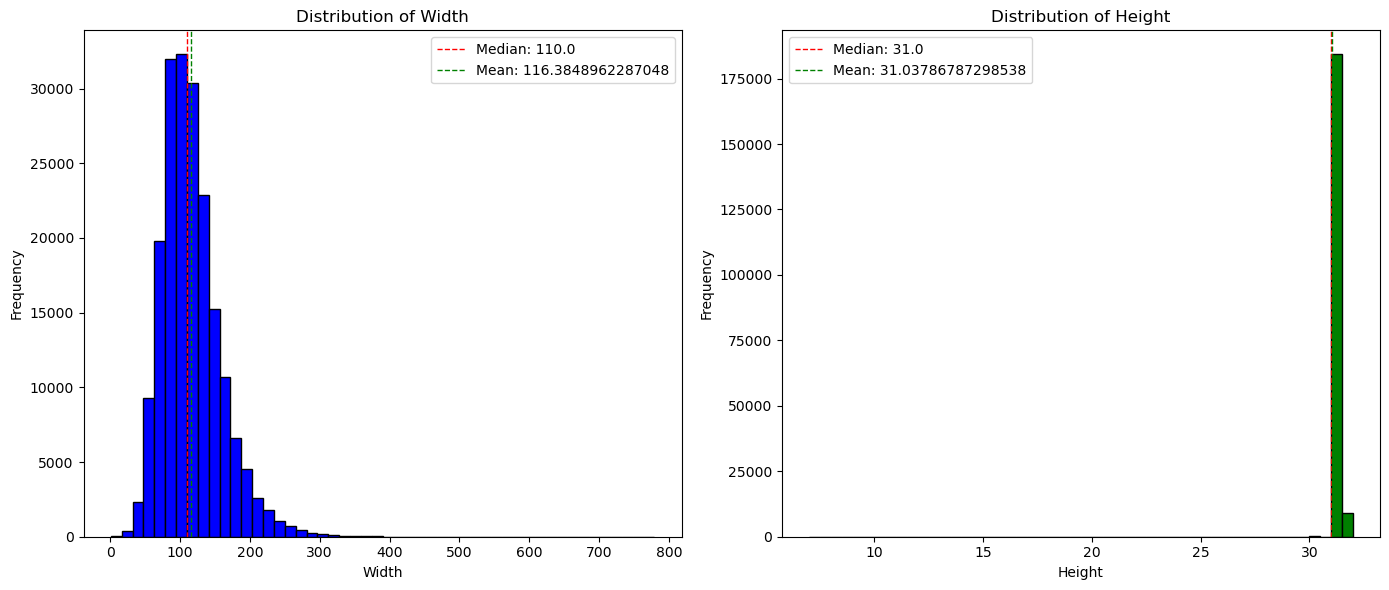

Estadísticas de Height:
count    193647.000000
mean         31.037868
std           0.339071
min           7.000000
25%          31.000000
50%          31.000000
75%          31.000000
max          32.000000
Name: height, dtype: float64

Estadísticas de Width:
count    193647.000000
mean        116.384896
std          42.084694
min           1.000000
25%          87.000000
50%         110.000000
75%         138.000000
max         779.000000
Name: width, dtype: float64


In [ ]:
# Calcular estadísticas
height_stats = train_data['height'].describe()
width_stats = train_data['width'].describe()

# Plotear las distribuciones
plt.figure(figsize=(14, 6))

# Distribución de width
plt.subplot(1, 2, 1)
plt.hist(train_data['width'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Width')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.axvline(train_data['width'].median(), color='red', linestyle='dashed', linewidth=1, label=f'Median: {train_data["width"].median()}')
plt.axvline(train_data['width'].mean(), color='green', linestyle='dashed', linewidth=1, label=f'Mean: {train_data["width"].mean()}')
plt.legend()

# Distribución de height
plt.subplot(1, 2, 2)
plt.hist(train_data['height'], bins=50, color='green', edgecolor='black')
plt.title('Distribution of Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.axvline(train_data['height'].median(), color='red', linestyle='dashed', linewidth=1, label=f'Median: {train_data["height"].median()}')
plt.axvline(train_data["height"].mean(), color='green', linestyle='dashed', linewidth=1, label=f'Mean: {train_data["height"].mean()}')
plt.legend()

plt.tight_layout()
plt.show()

# Mostrar estadísticas
print("Estadísticas de Height:")
print(height_stats)
print("\nEstadísticas de Width:")
print(width_stats)

optimal_height = train_data['height'].median()
optimal_width = train_data['width'].median()


In [4]:
train_data['label_length'] = train_data['label'].apply(len)

# Obtener estadísticas descriptivas sobre las longitudes de las etiquetas
labels_stats = train_data['label_length'].describe()
print(labels_stats)

count    193647.000000
mean          8.137028
std           2.501333
min           1.000000
25%           6.000000
50%           8.000000
75%          10.000000
max          22.000000
Name: label_length, dtype: float64


In [7]:
"""class CustomDataset(Dataset):
    def __init__(self, csv_file_path, transform=None):
        self.data_frame = pd.read_csv(csv_file_path)
        self.transform = transform
        self.label_to_index = {label: idx for idx, label in enumerate(self.data_frame['label'].unique())}

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx, 0]
        image = Image.open(img_name).convert('RGB')
        text = self.data_frame.iloc[idx, 1].lower()
        
        if self.transform:
            image = self.transform(image)

        return image, text"""

In [5]:
print(train_data)

                                               image_path       label  height   
0       /home/xnmaster/deep-learning-project-2024-ai_n...  classmates    31.0  \
1       /home/xnmaster/deep-learning-project-2024-ai_n...     greater    31.0   
2       /home/xnmaster/deep-learning-project-2024-ai_n...    bullfrog    31.0   
3       /home/xnmaster/deep-learning-project-2024-ai_n...     nuclear    31.0   
4       /home/xnmaster/deep-learning-project-2024-ai_n...  maximilian    31.0   
...                                                   ...         ...     ...   
193647  /home/xnmaster/deep-learning-project-2024-ai_n...   punchline    31.0   
193648  /home/xnmaster/deep-learning-project-2024-ai_n...      blares    31.0   
193649  /home/xnmaster/deep-learning-project-2024-ai_n...  undigested    31.0   
193650  /home/xnmaster/deep-learning-project-2024-ai_n...   saucepans    31.0   
193651  /home/xnmaster/deep-learning-project-2024-ai_n...    shabbily    31.0   

        width  label_length

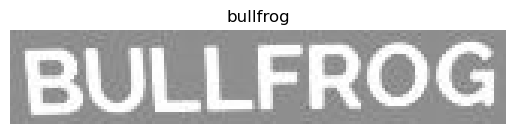

In [9]:
# Select a specific row, for example, the first row
image_path = train_data.iloc[2]['image_path']

# Open the image using PIL
image = Image.open(image_path)

# Plot the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.title(train_data.iloc[2]['label'])  # Optional: display the label as title
plt.show()

In [44]:
"""# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((110, 31)),  # Cambiar tamaño de la imagen
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizar con media y desviación estándar 0.5
])

# Crear dataset y dataloader
csv_file_path = 'train_data.csv'  # Reemplaza con la ruta a tu archivo CSV
train_dataset = CustomDataset(csv_file_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = CustomDataset('val_data.csv',transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


test_dataset = CustomDataset('test_data.csv',transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)"""

In [9]:
"""# Letters present in the Label Text
voc = '0123456789abcdefghijklmnopqrstuvwxyz'
num_classes = len(voc) + 1  # +1 for CTC blank label

def word2label(word):
    """
    #Transform a word into a vector.
    """
    return [voc.find(char) for char in word.lower()]

def label2word(labels):
    """
    #Recover de orginal label.
    """
    return ''.join([voc[ele] if ele < len(voc) else '' for ele in labels])"""

In [5]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch

class CustomDataset(Dataset):
    def __init__(self, data_frame, transform=None):
        self.data_frame = data_frame
        self.transform = transform
        self.voc = '0123456789abcdefghijklmnopqrstuvwxyz'
        self.num_classes = len(self.voc) + 1  # +1 para el carácter en blanco de CTC

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx, 0]
        try:
            image = Image.open(img_name).convert('RGB')
        except FileNotFoundError:
            print(f"File not found: {img_name}")
            return self.__getitem__((idx + 1) % len(self))  # Intentar con la siguiente imagen
        
        text = self.data_frame.iloc[idx, 1].lower()
        label = self.text_to_label(text)
        
        if self.transform:
            image = self.transform(image)

        return image, label, len(label)

    def text_to_label(self, text):
        return [self.voc.find(char) for char in text]

# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((32, 128)),  # Cambiar tamaño de la imagen
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizar con media y desviación estándar 0.5
])


# Crear dataset y dataloader
train_dataset = CustomDataset(train_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=lambda x: x)

val_dataset = CustomDataset(val_data, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=lambda x: x)

test_dataset = CustomDataset(test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=lambda x: x)


In [6]:
def custom_collate_fn(batch):
    images, labels, label_lengths = zip(*batch)

    images = torch.stack(images, 0)
    labels = [torch.tensor(label) for label in labels]
    label_lengths = torch.tensor(label_lengths)

    return images, labels, label_lengths


In [7]:
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=custom_collate_fn)


In [8]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            # Entrada: [batch_size, 1, 32, 128]
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Salida: [batch_size, 32, 32, 128]
            nn.SELU(),
            nn.MaxPool2d(2, 2),  # Salida: [batch_size, 32, 16, 64]
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Salida: [batch_size, 64, 16, 64]
            nn.SELU(),
            nn.MaxPool2d(2, 2),  # Salida: [batch_size, 64, 8, 32]
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Salida: [batch_size, 128, 8, 32]
            nn.SELU(),
            nn.MaxPool2d((2, 1)),  # Salida: [batch_size, 128, 4, 32]

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Salida: [batch_size, 256, 4, 32]
            nn.SELU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d((2, 1)),  # Salida: [batch_size, 256, 2, 32]

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # Salida: [batch_size, 512, 2, 32]
            nn.SELU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d((2, 1)),  # Salida: [batch_size, 512, 1, 32]
        )
        
        self.rnn = nn.LSTM(512, 128, bidirectional=True, batch_first=True, num_layers=2)  # Entrada: [batch_size, 31, 512], Salida: [batch_size, 31, 256]
        self.fc = nn.Linear(256, num_classes)  # Entrada: [batch_size, 31, 256], Salida: [batch_size, 31, num_classes]
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, nonlinearity='selu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, nonlinearity='selu')
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        init.kaiming_normal_(param, nonlinearity='selu')
                    elif 'bias' in name:
                        init.constant_(param, 0)

    def forward(self, x):
        # x inicial: [batch_size, 1, 32, 128]
        x = self.cnn(x)
        # Salida: [batch_size, 512, 1, 31]
        x = x.squeeze(2)  # Remover la dimensión 2 que es 1, resultado: [batch_size, 512, 31]
        x = x.permute(0, 2, 1)  # Reorganizar a [batch_size, 31, 512]
        
        x, _ = self.rnn(x)
        # Salida esperada: [batch_size, 31, 256]
        
        x = self.fc(x)
        # Salida esperada: [batch_size, 31, num_classes]
        
        return x 

In [21]:
num_classes = len(train_dataset.voc) + 1
model = CRNN(num_classes)
criterion = nn.CTCLoss(0)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

In [13]:
"""#Train with GPU if possible 
import torch
import torch.nn.functional as F

# Verificar la disponibilidad de CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 25


# Mover el modelo a la GPU
model = CRNN(num_classes).to(device)

# Durante el entrenamiento y validación, mover los datos a la GPU
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for idx, (images, labels, label_lengths) in enumerate(train_loader):
        images = images.to(device)
        labels = [label.to(device) for label in labels]
        label_lengths = label_lengths.to(device)
        
        optimizer.zero_grad()
        
        logits = model(images)
        log_probs = F.log_softmax(logits, dim=-1).permute(1, 0, 2)
        input_lengths = torch.full((logits.size(0),), logits.size(1), dtype=torch.long).to(device)
        labels_concat = torch.cat(labels)
        
        loss = criterion(log_probs, labels_concat, input_lengths, label_lengths)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # clip the grad to avoid gradients explosion.
        loss.backward()
        optimizer.step()
        if idx%25==0:
            print(f"epoch: {epoch}, batch:{idx} loss: {loss.item()}")
        train_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader)}')

model.eval()
val_loss = 0.0
with torch.no_grad():
    for images, labels, label_lengths in val_loader:
        images = images.to(device)
        labels = [label.to(device) for label in labels]
        label_lengths = label_lengths.to(device)

        logits = model(images)
        log_probs = logits.log_softmax(2)
        input_lengths = torch.full((logits.size(0),), logits.size(1), dtype=torch.long).to(device)
        labels_concat = torch.cat(labels)
        
        loss = criterion(log_probs, labels_concat, input_lengths, label_lengths)
        val_loss += loss.item()

print(f'Validation Loss: {val_loss/len(val_loader)}')"""

NameError: name 'num_classes' is not defined

In [ ]:
torch.save(model.state_dict(), "model_final.pth")

In [14]:
# Loop de entrenamiento con wandb y uso de GPU
import torch.nn.functional as F
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    device = 'cuda'
else:
    print("CUDA is not available. PyTorch will use the CPU.")

num_classes = len(train_dataset.voc) + 1
model = CRNN(num_classes).to(device)
criterion = nn.CTCLoss(0)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate,weight_decay=config.weight_decay)

c = 0

wandb.watch(model,criterion,log='all',log_freq=2)
for epoch in range(config.num_epochs):
    model.train()
    train_loss = 0.0

    for images, labels, label_lengths in train_loader:

        images = images.to(device)
        labels = [label.to(device) for label in labels]
        label_lengths = label_lengths.to(device)
        
        optimizer.zero_grad()
        #print(images.shape)
        logits = model(images)
        #print(logits.shape)
        #print(logits)
        log_probs = F.log_softmax(logits, dim=-1).permute(1, 0, 2)  # Transponer logits para que tenga la forma (T, N, C) T= sequence length N = batch and C classes
        input_lengths = torch.full((logits.size(0),), logits.size(1), dtype=torch.long).to(device)
        labels_concat = torch.cat(labels).to(device)

        loss = criterion(log_probs, labels_concat, input_lengths, label_lengths)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        
        train_loss += loss.item()
        print(train_loss)
    
    avg_train_loss = train_loss / len(train_loader)
    wandb.log({"epoch": epoch + 1, "train_loss": avg_train_loss})

    print(f'Epoch {epoch+1}/{config.num_epochs}, Loss: {avg_train_loss}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels, label_lengths in val_loader:
            images = images.to(device)
            labels = [label.to(device) for label in labels]
            label_lengths = label_lengths.to(device)
            
            logits = model(images)
            #log_probs = logits.log_softmax(2)
            log_probs = F.log_softmax(logits, dim=-1).permute(1, 0, 2)
            input_lengths = torch.full((logits.size(0),), logits.size(1), dtype=torch.long).to(device)
            labels_concat = torch.cat(labels).to(device)
            
            loss = criterion(log_probs, labels_concat, input_lengths, label_lengths)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    wandb.log({"epoch": epoch + 1, "val_loss": avg_val_loss})

    print(f'Validation Loss: {avg_val_loss}')

# Guardar el modelo al final del entrenamiento
torch.save(model.state_dict(), "modelv1.pth")
wandb.save("modelv1.pth")

CUDA is available. PyTorch can use the GPU.
Device name: Tesla V100-PCIE-16GB
12.575250625610352
24.687520027160645
35.89716053009033
46.1984167098999
55.95619010925293


KeyboardInterrupt: 

In [38]:
modelprueba = CRNN(num_classes).to(device)
modelprueba.load_state_dict(torch.load("modelv1.pth"))

<All keys matched successfully>

In [42]:
import torch.nn as nn
import torch.optim as optim
import wandb

# Definir el decodificador CTC
def ctc_decode(log_probs, voc):
    """
    Decodificar las probabilidades de salida de la RNN para obtener la secuencia de texto.

    log_probs: Salida logarítmica del modelo RNN después de aplicar softmax (T, N, C)
    voc: El vocabulario usado para el mapeo de caracteres
    """
    # Obtener los índices con la mayor probabilidad en cada timestep
    max_probs = torch.argmax(log_probs, dim=-1)
    
    decoded_batch = []
    for sequence in max_probs.permute(1, 0):  # Cambiar a (N, T)
        decoded_sequence = []
        previous_char = None
        for index in sequence:
            char = voc[index] if index < len(voc) else ''
            if char != previous_char:  # Eliminar duplicados consecutivos
                decoded_sequence.append(char)
            previous_char = char
        decoded_sequence = ''.join([char for char in decoded_sequence if char != ''])  # Eliminar caracteres en blanco
        decoded_batch.append(decoded_sequence)
    return decoded_batch

# Simular el paso de decodificación después de la inferencia del modelo

modelprueba.eval()
with torch.no_grad():
    for images, _, _ in train_loader:
        images = images.to(device)
        logits = modelprueba(images)
        log_probs = F.log_softmax(logits, dim=-1).permute(1, 0, 2)  # (T, N, C)
        # Decodificar las probabilidades de salida para obtener el texto
        predicted_texts = ctc_decode(log_probs, train_dataset.voc)
        print(predicted_texts)
     

torch.Size([128, 512, 32, 8])
['0', '0s', '0', '0', '0s', '0s', '0s', '0s', '0', '0', '0', '0', '0', '0s', '0s', '0s', '0', '0', '0s', '0', '0', '0s', '0s', '0', '0s', '0s', '0s', '0', '0', '0', '0s', '0s', '0', '0s', '0', '0s', '0', '0s', '0s', '0', '0', '0s', '0s', '0', '0s', '0', '0', '0', '0s', '0', '0', '0', '0', '0s', '0', '0', '0s', '0s', '0', '0', '0', '0', '0s', '0', '0s', '0', '0s', '0s', '0s', '0', '0', '0', '0', '0s', '0s', '0', '0', '0s', '0', '0', '0', '0s', '0s', '0', '0s', '0', '0s', '0', '0', '0s', '0', '0', '0', '0', '0s', '0', '0', '0s', '0s', '0s', '0', '0', '0', '0', '0s', '0s', '0s', '0', '0', '0s', '0s', '0', '0', '0', '0s', '0s', '0s', '0', '0s', '0s', '0s', '0s', '0', '0', '0s', '0', '0', '0s']
torch.Size([128, 512, 32, 8])
['0s', '0', '0', '0', '0', '0', '0s', '0s', '0s', '0', '0', '0s', '0', '0', '0s', '0s', '0s', '0s', '0s', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0s', '0s', '0', '0s', '0', '0s', '0s', '0s', '0', '0', '0', '0', '0s', '0', '0s

KeyboardInterrupt: 

In [9]:
import torch.nn.functional as F
import torch.nn.init as init
import wandb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def ctc_decode(log_probs, voc):
    """
    Decodificar las probabilidades de salida de la RNN para obtener la secuencia de texto.

    log_probs: Salida logarítmica del modelo RNN después de aplicar softmax (T, N, C)
    voc: El vocabulario usado para el mapeo de caracteres
    """
    max_probs = torch.argmax(log_probs, dim=-1)
    decoded_batch = []
    for sequence in max_probs.permute(1, 0):  # Cambiar a (N, T)
        decoded_sequence = []
        previous_char = None
        for index in sequence:
            if index < len(voc):
                char = voc[index]
                if char != previous_char:  # Eliminar duplicados consecutivos
                    decoded_sequence.append(char)
                previous_char = char
        decoded_sequence = ''.join([char for char in decoded_sequence if char != ''])  # Eliminar caracteres en blanco
        decoded_batch.append(decoded_sequence)
    return decoded_batch

def calculate_accuracy(pred_texts, true_texts):
    """
    Calcula la precisión a nivel de palabra y carácter.

    pred_texts: Textos predichos por el modelo
    true_texts: Textos verdaderos
    """
    word_accuracy = accuracy_score(true_texts, pred_texts)
    
    total_chars = sum(len(text) for text in true_texts)
    correct_chars = sum(sum(p == t for p, t in zip(pred, true)) for pred, true in zip(pred_texts, true_texts))
    char_accuracy = correct_chars / total_chars if total_chars > 0 else 0

    return word_accuracy, char_accuracy

# Inicialización de WandB
wandb.init(project="CRNN_Testing", entity="luisdomene")

# Registrar hiperparámetros
config = wandb.config
config.learning_rate = 0.0003
config.weight_decay = 0.0005
config.batch_size = 512
config.num_epochs = 25

if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    device = 'cuda'
else:
    print("CUDA is not available. PyTorch will use the CPU.")
    device = 'cpu'

num_classes = len(train_dataset.voc) + 1
model = CRNN(num_classes).to(device)
criterion = nn.CTCLoss(blank=0)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

# Reducción del Learning Rate en Plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

best_val_loss = float('inf')
wandb.watch(model, criterion, log='all', log_freq=10)

for epoch in range(config.num_epochs):
    model.train()
    train_loss = 0.0

    for images, labels, label_lengths in train_loader:
        images = images.to(device)
        labels = [label.to(device) for label in labels]
        label_lengths = label_lengths.to(device)
        
        optimizer.zero_grad()
        logits = model(images)
        log_probs = F.log_softmax(logits, dim=-1).permute(1, 0, 2)
        input_lengths = torch.full((logits.size(0),), logits.size(1), dtype=torch.long).to(device)
        labels_concat = torch.cat(labels).to(device)

        loss = criterion(log_probs, labels_concat, input_lengths, label_lengths)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    wandb.log({"epoch": epoch + 1, "train_loss": avg_train_loss})

    print(f'Epoch {epoch+1}/{config.num_epochs}, Train Loss: {avg_train_loss}')

    model.eval()
    val_loss = 0.0
    all_pred_texts = []
    all_true_texts = []
    
    with torch.no_grad():
        for images, labels, label_lengths in val_loader:
            images = images.to(device)
            labels = [label.to(device) for label in labels]
            label_lengths = label_lengths.to(device)
            
            logits = model(images)
            log_probs = F.log_softmax(logits, dim=-1).permute(1, 0, 2)
            input_lengths = torch.full((logits.size(0),), logits.size(1), dtype=torch.long).to(device)
            labels_concat = torch.cat(labels).to(device)
            
            loss = criterion(log_probs, labels_concat, input_lengths, label_lengths)
            val_loss += loss.item()

            # Decodificar y calcular la precisión
            pred_texts = ctc_decode(log_probs, train_dataset.voc)
            true_texts = ["".join([train_dataset.voc[char] for char in label]) for label in labels]
            all_pred_texts.extend(pred_texts)
            all_true_texts.extend(true_texts)
            
    avg_val_loss = val_loss / len(val_loader)
    word_acc, char_acc = calculate_accuracy(all_pred_texts, all_true_texts)
    wandb.log({"epoch": epoch + 1, "val_loss": avg_val_loss, "word_accuracy": word_acc, "char_accuracy": char_acc})

    print(f'Validation Loss: {avg_val_loss}, Word Accuracy: {word_acc}, Char Accuracy: {char_acc}')

    # Ajustar el learning rate en función de la pérdida de validación
    scheduler.step(avg_val_loss)

    # Visualizar imágenes con predicciones cada 5 epochs
    if (epoch + 1) % 10 == 0:
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        axs = axs.flatten()
        for i in range(4):  # Visualizar hasta 4 ejemplos
            if i < len(images):
                axs[i].imshow(images[i].cpu().numpy().transpose(1, 2, 0), cmap='gray')
                axs[i].set_title(f'Pred: {all_pred_texts[i]}\nTrue: {all_true_texts[i]}')
                axs[i].axis('off')
        plt.tight_layout()
        wandb.log({"epoch_image": wandb.Image(fig, caption=f"Epoch {epoch+1}")})
        plt.close(fig)

    # Guardar el modelo si se obtiene una mejor pérdida de validación
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")
        wandb.save(f"model_epoch_{epoch+1}.pth")

# Guardar el modelo al final del entrenamiento
torch.save(model.state_dict(), "modelv_def.pth")
wandb.save("modelv_def.pth")

CUDA is available. PyTorch can use the GPU.
Device name: Tesla V100-PCIE-16GB
Epoch 1/25, Train Loss: 3.185691257894511
Validation Loss: 2.6267519354820252, Word Accuracy: 0.0, Char Accuracy: 0.022430364248546067
Epoch 2/25, Train Loss: 1.6309816628144096
Validation Loss: 0.9244305163621902, Word Accuracy: 0.0, Char Accuracy: 0.12344046525864708
Epoch 3/25, Train Loss: 0.700839401156418
Validation Loss: 0.6095716416835785, Word Accuracy: 0.0, Char Accuracy: 0.1290602999693909
Epoch 4/25, Train Loss: 0.5283828523983113
Validation Loss: 0.5111771449446678, Word Accuracy: 0.0, Char Accuracy: 0.12880318334863788
Epoch 5/25, Train Loss: 0.45415493460632567
Validation Loss: 0.4659761145710945, Word Accuracy: 0.0, Char Accuracy: 0.13074992347719622
Epoch 6/25, Train Loss: 0.4100075448251337
Validation Loss: 0.4239072620868683, Word Accuracy: 0.0, Char Accuracy: 0.13003979185797368
Epoch 7/25, Train Loss: 0.3797444002923991
Validation Loss: 0.4184886321425438, Word Accuracy: 0.0, Char Accuracy

In [ ]:
print(len(train_loader))

24


In [ ]:
w

In [3]:
wandb.finish()

In [7]:
!python -c "import torch; print('PyTorch version:', torch.__version__); print('CUDA available:', torch.cuda.is_available()); print('CUDA version:', torch.version.cuda)"


PyTorch version: 1.12.0
CUDA available: True
CUDA version: 11.6


In [19]:
!nvidia-smi


Tue May 28 22:50:07 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.239.06   Driver Version: 470.239.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000001:00:00.0 Off |                  Off |
| N/A   28C    P0    26W / 250W |     81MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------